# Rapprochement

In [2]:
import csv
import json
import time
from batid.utils.misc import is_float
from batid.services.pairing_bdgs import pair

In [46]:
# ##############
# Define utilities

def rowToParams(row) -> dict: 
    
    address_infos = [row["Numéro, type et nom de la voie"], row["Code postal"], row["Commune Nom"]]
    address_infos = [info for info in address_infos if info is not None]
    
    return {
        'ext_id': row["Numéro de l'équipement sportif"],
        'name': row["Nom de l'installation sportive"],
        'address': ", ".join(address_infos),
        'lat': float(row['Latitude (WGS84)']) if is_float(row['Latitude (WGS84)']) else None,
        'lng': float(row['Longitude (WGS84)']) if is_float(row['Longitude (WGS84)']) else None,
        'radius': 100
    }

def results_to_report(results) -> dict:
    report = {}
    for ext_id, result_row in results.items():
        report_row = result_row
        if result_row['result'] is not None:
            report_row['result'] = {
                'rnb_id': report_row['result'].rnb_id,
                'distance': report_row['result'].distance.m,
                'point': f"{report_row['result'].point[1]},{report_row['result'].point[0]}"
            }
        report[ext_id] = report_row
    
    return report

# #########
# Le rapprochement

start = time.perf_counter()
with open('data/data-es.csv') as f:
    reader = csv.DictReader(f, delimiter=';')
    raw = list(reader)

    data = []
    for row in raw:
        params = rowToParams(row)
        if params['lat'] and params['lng']:
            data.append(params)
    
results = pair(data, 'closest')
report = results_to_report(results)

        
with open('results/closest.json', 'w') as f:
    json.dump(report, f)
    
elapsed = time.perf_counter() - start


print('-- Fini --')
print(f"Lignes CSV : {len(raw)}")
print(f"Rapprochement tentés : {len(data)}")
print(f"Temps passé {elapsed:02f} secondes")
print(f"Temps moyen par ligne : {elapsed / len(raw)} secondes")




-- Fini --
Lignes CSV : 86082
Rapprochement tentés : 85298
Temps passé 547.777550 secondes
Temps moyen par ligne : 0.006363438926918516 secondes


# Report

-- Total rows in original csv
86082
-- Rows with pairing try
85298
-- Distance = 0
42015
-- Distance <= 1
46897
-- Distance médiane
0.07603072
-- Hist et percentiles des bâtiments éloignés de plus de 1m --
[[<Axes: title={'center': 'r_distance'}>]]
         r_distance
count  37773.000000
mean      10.124707
std       12.263583
min        1.000859
10%        1.756693
20%        2.551409
30%        3.468731
40%        4.538865
50%        5.845964
60%        7.721889
70%       10.228015
80%       14.288634
90%       23.055445
max       99.590332


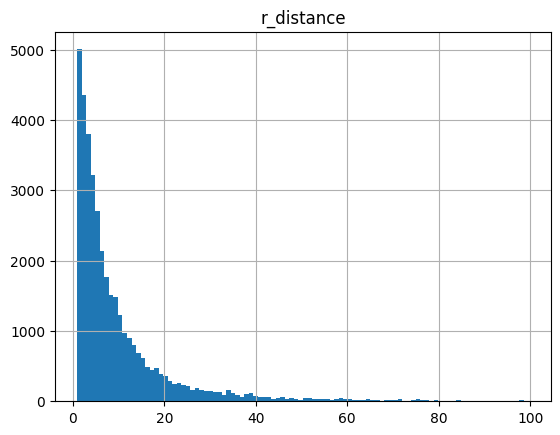

In [7]:
import pandas as pd
from pprint import pprint

with open('data/data-es.csv') as f:
    reader = csv.DictReader(f, delimiter=';')
    raw_count = len(list(reader))


with open('results/closest.json', 'r') as f:
    report = json.load(f)
    
data = []
for ext_id, row in report.items():
    
    data.append({
        'q_ext_id': ext_id,
        'q_latlng': f"{row['params']['lat']},{row['params']['lng']}",
        'q_address': row['params']['address'],
        'q_name': row['params']['name'],
        'r_rnb_id': row['result']['rnb_id'] if row['result'] is not None else None,
        'r_distance': row['result']['distance'] if row['result'] is not None else None,
        'r_point': row['result']['point'] if row['result'] is not None else None
    })
    
df = pd.DataFrame(data)


print('-- Total rows in original csv')
print(raw_count)

print('-- Rows with pairing try')
print(len(data))

print('-- Distance = 0')
print((df["r_distance"] == 0).sum())

print('-- Distance <= 1')
print((df["r_distance"] <= 1).sum())

print('-- Distance médiane')
print((df["r_distance"]).median())

print('-- Hist et percentiles des bâtiments éloignés de plus de 1m --')
print(df[df['r_distance'] > 1].hist(bins=100))
print(df[df['r_distance'] > 1].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]))


On va étudier les bâtiments qui sont entre 1 et 10 mètres du point demandé. Cela couvre 70% des lignes dont le meilleur résultat est éloigné de plus de 1m

## Echantillon des trop loin

In [10]:
size = 20
filtered_df = df[(df['r_distance'] > 1) & (df['r_distance'] <= 10)].head(size)

filtered_df

,q_ext_id,q_latlng,q_address,q_name,r_rnb_id,r_distance,r_point
4,E001I010040008,"45.96153,5.34887","Avenue Léon Blum, 01500, Ambérieu-en-Bugey",Gymnase Plaine de l'Ain,6P69FCGA7P6D,3.679259,"45.961982947926046,5.3489764842928835"
5,E001I010140007,"46.29416,5.67777","Rue de Lac, 01100, Arbent",PETANQUE ARBENT-MARCHON (P.A.M.),MX5BTY3NN4MK,3.298043,"46.29415365710709,5.677403828514942"
7,E004I010310002,"46.25055,5.63222","Rue Pierre et Marie Curie, 01100, Bellignat",GYMNASE DU PRE DES SAULES,VK29HFYKRG5H,5.108687,"46.25035672102649,5.631839337451984"
10,E001I010250001,"46.31777,4.945","Route de Charlemagne, 01380, Bâgé-Dommartin",Complexe sportif intercommunal,F816PJWBT448,7.815793,"46.317476744824646,4.945039413064757"
11,E003I010040017,"45.9632,5.34556","Rue Marcel Paul, 01500, Ambérieu-en-Bugey",Salle Marcel Paul EDF/GDF,ZVTBVK8E2HRT,2.373613,"45.96335365030969,5.345555235003049"
13,E001I010040001,"45.96155,5.34428","Avenue de Mering, 01500, Ambérieu-en-Bugey",Centre nautique Laure Manaudou,EDFZZEQADNZF,8.050027,"45.96168275835872,5.344584204316998"
15,E003I010040018,"45.97377,5.35084","223 Rue Alexandre Bérard, 01500, Ambérieu-en-B...",Lycée Pro Alexandre Bérard,Z5K1J9PFWMGH,2.750663,"45.97388018676705,5.350937281105363"
20,E006I010270004,"45.83361,5.10389","Rue du Stade, 01360, Balan",Complexe sportif,QA8X13Q4SK9F,1.690528,"45.83362933958759,5.10393829140211"
22,E002I010040011,"45.95527,5.33722","Avenue Gérard Sarrail, 01500, Ambérieu-en-Bugey","Espace multiactivités ""Immeuble Phoenix""",VYCV39WK79YX,2.715013,"45.95535858924978,5.3371904884747305"
23,E001I010210005,"45.9908,4.8175","Chemin du Bois de la Dame, 01480, Ars-sur-Formans",SALLE POLYVALENTE,948ZRKT7JPVA,8.592192,"45.990538194768654,4.81737846001432"
